In [11]:
from stock_data import Stock
import statsmodels.tsa.stattools as stattools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os


# Finding stocks that move together
## Data setup
First of all, we construct the stock objects and filter them by industry. The following are the industries available:  

`['Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Discretionary', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Consumer Staples', 'Energy']`

The data for all stocks is one minute data from **03/02/2020** to **30/04/2020** from **9:30am** to **4:00pm**.

Using the `Stock` class from the `stock_data` file, we can turn the one minute data into data of any (less granular) time interval by using the aggregating methods.

In [12]:
BY_INDUSTRY = Stock.all_by_industry()
INDUSTRIES = BY_INDUSTRY.keys()
plt.style.use('seaborn-dark-palette')

In [13]:
all_stocks = Stock.all_stocks()
if False:
    for plotted_stock in all_stocks:
        plotted_data = plotted_stock.five_minute()

        time, price = plotted_data['time'], plotted_data['price']

        plt.plot(time, price)
        plt.title(f"Price of {plotted_stock.name} using 5 min intervals")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")

        plt.gca().set_ylim(bottom=0)
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.savefig(f"all_stocks_figures/{plotted_stock.name}.png")
        plt.clf()

In [14]:
len(Stock.LIST)

503

## Analysis
With the multiple sectors there are to choose from, its important to choose a sector that is likely to have pairs of stocks that move together.

As our dataset is 

# Calculating pvalues for 5 min data over 1.5 months (half the time period)

In [15]:
date_object = datetime.strptime("11/10/2000", "%d/%m/%Y")
start = datetime.strptime("03/02/2020", "%d/%m/%Y")
end = datetime.strptime("18/03/2020", "%d/%m/%Y")

In [16]:
data = BY_INDUSTRY["Energy"][0].five_minute()
data[int(data.shape[0]/2):]

,time,price
2449,2020-03-18 09:30:00,4.134158
2450,2020-03-18 09:35:00,4.263084
2451,2020-03-18 09:40:00,4.315023
2452,2020-03-18 09:45:00,4.318487
2453,2020-03-18 09:50:00,4.397166
...,...,...
4893,2020-04-30 15:40:00,12.963038
4894,2020-04-30 15:45:00,12.940485
4895,2020-04-30 15:50:00,13.048879
4896,2020-04-30 15:55:00,13.054834


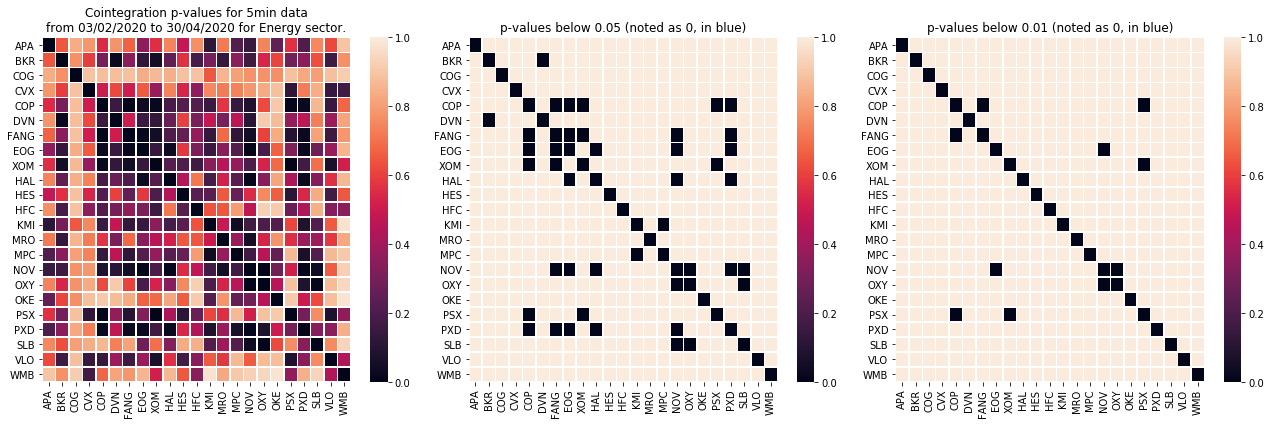

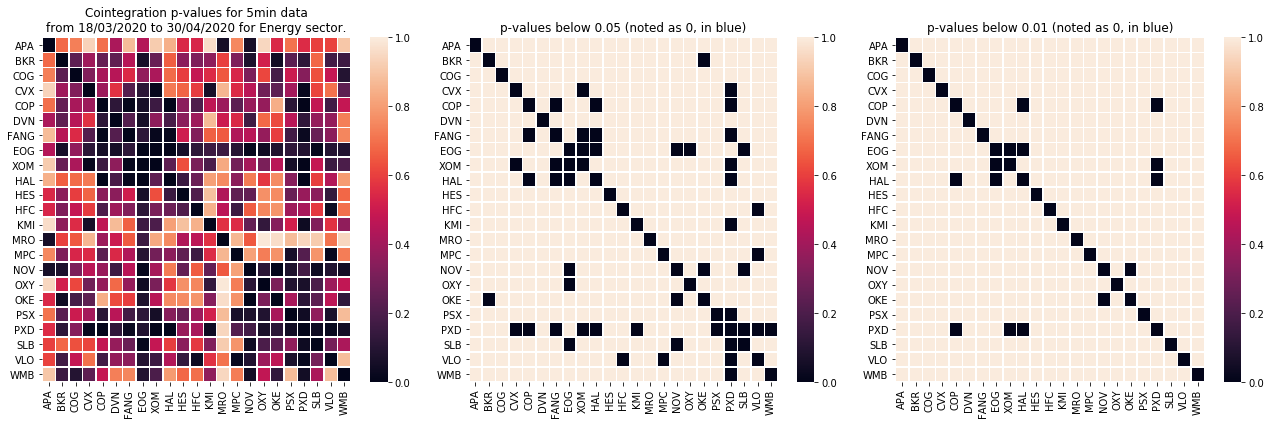

Full timeframe:
{'info': "sector=Energy,granularity=5,time_window=['03/02/2020', '30/04/2020']", 'p-values': {0.05: [('BKR', 'DVN'), ('COP', 'FANG'), ('COP', 'EOG'), ('COP', 'XOM'), ('COP', 'PSX'), ('COP', 'PXD'), ('FANG', 'EOG'), ('FANG', 'XOM'), ('FANG', 'NOV'), ('FANG', 'PXD'), ('EOG', 'HAL'), ('EOG', 'NOV'), ('EOG', 'PXD'), ('XOM', 'PSX'), ('HAL', 'NOV'), ('HAL', 'PXD'), ('KMI', 'MPC'), ('NOV', 'OXY'), ('NOV', 'PXD'), ('NOV', 'SLB'), ('OXY', 'SLB')], 0.01: [('COP', 'FANG'), ('COP', 'PSX'), ('EOG', 'NOV'), ('XOM', 'PSX'), ('NOV', 'OXY')]}} 

1.5 month timeframe:
{'info': "sector=Energy,granularity=5,time_window=['18/03/2020', '30/04/2020']", 'p-values': {0.05: [('BKR', 'OKE'), ('CVX', 'XOM'), ('CVX', 'PXD'), ('COP', 'FANG'), ('COP', 'HAL'), ('COP', 'PXD'), ('FANG', 'XOM'), ('FANG', 'HAL'), ('FANG', 'PXD'), ('EOG', 'XOM'), ('EOG', 'HAL'), ('EOG', 'NOV'), ('EOG', 'OXY'), ('EOG', 'SLB'), ('XOM', 'PXD'), ('HAL', 'PXD'), ('HFC', 'VLO'), ('KMI', 'PXD'), ('MPC', 'VLO'), ('NOV', 'OKE'), ('N

In [17]:
import seaborn as sns

def path_date(date):
    return date.replace("/", "-")
def cointegration_analysis_loop(stock_lst,
                                sector,
                                time_window=["03/02/2020", "30/04/2020"],
                                save_figures: bool = False,
                                save_folder:str = None,
                                granularity=5):
    """
    Takes a list of stock objects, a time window (list of date strings [start,end]),
    whether to save the figures or not, and if so, the folder to save the figures.
    """
    # Parsing time_window
    start, end = time_window
    start = datetime.strptime(start, "%d/%m/%Y")
    end = datetime.strptime(end, "%d/%m/%Y")
    
    stock_data_lst = []
    for stock in stock_lst: # Trimming the data to the region of interest
        data = stock.any_minute(granularity)
        mask = (start < data["time"])&(data["time"] < end)
        data = data[mask]
        stock_data_lst.append(data)
    
    
    p_values = np.zeros((len(stock_lst), len(stock_lst)))
    
    for stock1_index in range(len(stock_data_lst)): # Looping through all stocks
        for stock2_index in range(stock1_index+1, len(stock_data_lst)): # Looping from stock1_index to the end

            # Getting the pair of stocks over half the total time period
            both_stock_data = [stock_data_lst[stock1_index],
                               stock_data_lst[stock2_index]]

            _, p_value, _ = stattools.coint(both_stock_data[0]["price"], both_stock_data[1]["price"])

            p_values[stock1_index, stock2_index] = p_value
            p_values[stock2_index, stock1_index] = p_value
    
    labels = [stock.name for stock in stock_lst]
    
    fig, axs = plt.subplots(1,3)#(nrows,ncols)
    plot_size = fig.get_size_inches()
    fig.set_size_inches(plot_size[0]*3, plot_size[1]*1.5)
    
    # Plotting the first graph (p_values heatmap)
    sns.heatmap(p_values, linewidth=0.5, ax=axs[0], vmin=0, vmax=1)
    axs[0].set_title(f"Cointegration p-values for {granularity}min data\nfrom {time_window[0]} to {time_window[1]} for {sector} sector.")
    axs[0].set_xticks(np.arange(len(labels))+0.5) # Making sure each tick appears on the plot
    axs[0].set_yticks(np.arange(len(labels))+0.5) # Making sure each tick appears on the plot
    
    axs[0].set_xticklabels(labels, rotation=90) # Rotating axis labels and setting labels
    axs[0].set_yticklabels(labels, rotation=0)
    
    
    # Plotting the second graph (booleans of pairs <0.05)
    sns.heatmap(p_values>0.05, linewidth=0.5, ax=axs[1], vmin=0, vmax=1)
    axs[1].set_title(f"p-values below 0.05 (noted as 0, in blue)")
    axs[1].set_xticks(np.arange(len(labels))+0.5) # Making sure each tick appears on the plot
    axs[1].set_yticks(np.arange(len(labels))+0.5) # Making sure each tick appears on the plot
    
    axs[1].set_xticklabels(labels, rotation=90) # Rotating axis labels and setting labels
    axs[1].set_yticklabels(labels, rotation=0)
    
    
    # Plotting the third graph (booleans of pairs <0.01)
    sns.heatmap(p_values>0.01, linewidth=0.5, ax=axs[2], vmin=0, vmax=1)
    axs[2].set_title(f"p-values below 0.01 (noted as 0, in blue)")
    axs[2].set_xticks(np.arange(len(labels))+0.5) # Making sure each tick appears on he plot
    axs[2].set_yticks(np.arange(len(labels))+0.5) # Making sure each tick appears on he plot
    
    axs[2].set_xticklabels(labels, rotation=90) # Rotating axis labels and setting labels
    axs[2].set_yticklabels(labels, rotation=0)
    
    
    if save_figures:
        if save_folder is None:
            raise Exception("Please specify save_folder")
        plt.tight_layout()
        plt.savefig(os.path.join(save_folder, f"sector={sector}_{path_date(time_window[0])}to{path_date(time_window[1])}_{granularity}.png"))
    plt.show()
    
    # Constructing dictionaries of cointegrated pairs
    output_dic = {"info": f"sector={sector},granularity={granularity},time_window={time_window}",
                  "p-values":{
                      0.05: [],
                      0.01: []
                  }}
    
    
    for row_index in range(len(p_values)):
        for col_index in range(row_index + 1, len(p_values)):
            p_value = p_values[row_index, col_index]
            
            stock1, stock2 = stock_lst[row_index], stock_lst[col_index]
            
            if p_value <= 0.05:
                output_dic["p-values"][0.05].append((stock1.name,
                                                    stock2.name))
            if p_value <= 0.01:
                output_dic["p-values"][0.01].append((stock1.name,
                                                    stock2.name))

    return output_dic

def and_lst(lst1, lst2):
    out_lst = []
    for element in lst1:
        if element in lst2:
            out_lst.append(element)
            
    return out_lst
        

dic1 = cointegration_analysis_loop(stock_lst=BY_INDUSTRY["Energy"],
                                   sector="Energy",
                                   save_figures=True,
                                   save_folder="report_figures")
dic2 = cointegration_analysis_loop(stock_lst=BY_INDUSTRY["Energy"],
                                   sector="Energy",
                                   save_figures=True,
                                   time_window=["18/03/2020", "30/04/2020"],
                                   save_folder="report_figures")


print("Full timeframe:")
print(dic1, "\n")
print("1.5 month timeframe:")
print(dic2, "\n")

In [18]:
and_lst(dic1["p-values"][0.01], dic2["p-values"][0.01])

[]

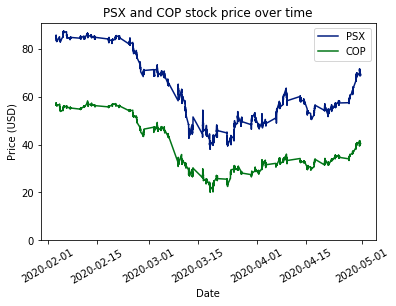

In [19]:
def plot_compare(stock_lst, save_folder = None):
    data_lst = [stock.one_minute()["price"] for stock in stock_lst]
    time = stock_lst[0].one_minute()["time"]
    
    stock_name_lst = [stock.name for stock in stock_lst]
    
    plt.style.use('seaborn-dark-palette')
    for data_index in range(len(data_lst)):
        plt.plot(time, data_lst[data_index], label=f"{stock_lst[data_index].name}")
    
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=30)
    plt.legend()
    
    plt.gca().set_ylim(bottom=0)
    
    plt.title(f"{' and '.join(stock_name_lst)} stock price over time")
    
    if save_folder is not None:
        plt.tight_layout()
        plt.savefig(os.path.join(save_folder, f"plot_{'_'.join(stock_name_lst)}.png"))
    
    plt.show()
    return

plot_compare([Stock("PSX"), Stock("COP")])#, save_folder = "report_figures")

# A relationship between correlation and cointegration

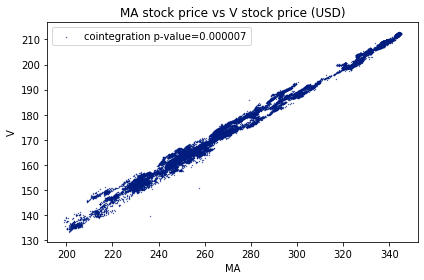

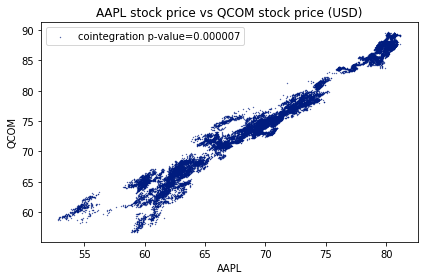

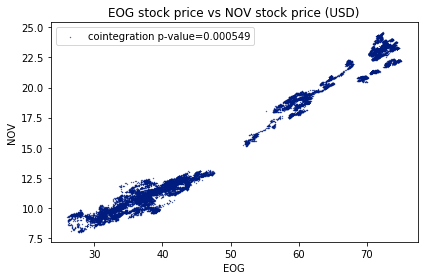

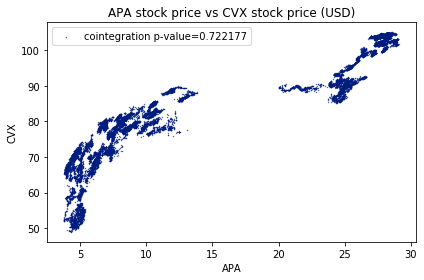

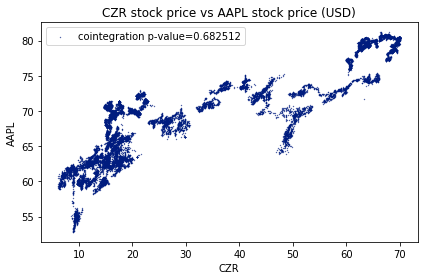

In [8]:
def correlation_plot(stock1, stock2, save_folder = None):
    data1 = stock1.one_minute()["price"]
    data2 = stock2.one_minute()["price"]
    _, p_value, _ = stattools.coint(data1, data2)

    plt.scatter(data1, data2, s=0.1, label=f"cointegration p-value={p_value:.6f}")
    plt.xlabel(stock1.name)
    plt.ylabel(stock2.name)
    plt.legend()
    plt.title(f"{stock1.name} stock price vs {stock2.name} stock price (USD)")
    
    if save_folder is not None:
        plt.tight_layout()
        plt.savefig(os.path.join(save_folder, f"correlation_{stock1.name}_{stock2.name}.png"))
    
    plt.show()
    return

#Cointegrated
correlation_plot(stock1 = Stock("MA"),
                 stock2 = Stock("V"),
                 save_folder = "report_figures")
correlation_plot(stock1 = Stock("AAPL"),
                 stock2 = Stock("QCOM"),
                 save_folder = "report_figures")

correlation_plot(stock1 = Stock("EOG"),
                 stock2 = Stock("NOV"),
                 save_folder = "report_figures")

# Not cointegrated
correlation_plot(stock1 = Stock("APA"),
                 stock2 = Stock("CVX"),
                 save_folder = "report_figures")

correlation_plot(stock1 = Stock("CZR"),
                 stock2 = Stock("AAPL"),
                 save_folder = "report_figures")

In [9]:
_, p_value, _ = stattools.coint([2*x for x in range(1000)], [x for x in range(1000)])

C:\Users\nickh\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1398: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning)


In [10]:
p_value

0.0

## Standardised difference

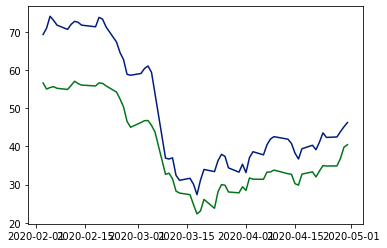

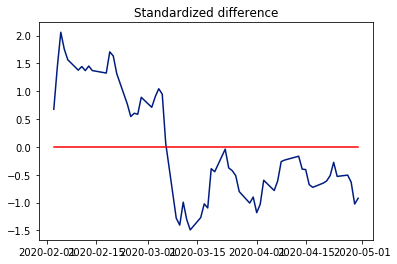

In [11]:
plot_stocks = [Stock("EOG"), Stock("COP")]
plot_stocks_daily = [stock.any_minute(24*60) for stock in plot_stocks]

plt.plot(plot_stocks_daily[0]["time"], plot_stocks_daily[0]["price"])
plt.plot(plot_stocks_daily[1]["time"], plot_stocks_daily[1]["price"])
plt.show()

price_data = [data["price"] for data in plot_stocks_daily]
delta = price_data[0]-price_data[1]
z_delta = (delta-delta.mean())/np.std(delta)
plt.plot(plot_stocks_daily[1]["time"], z_delta)
plt.plot(plot_stocks_daily[1]["time"], np.zeros_like(z_delta), color="red")
plt.title("Standardized difference")
plt.show()